## Importing Libraries

In [8]:
import warnings
warnings.filterwarnings('ignore')

try:
  import yfinance as yf
except:
  !pip install -q yfinance
  import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date, timedelta

## Getting Historical Data

In [51]:
df = yf.download("SPY",
                 start=date.today()-timedelta(365*50),
                 end=date.today(),
                 progress=False
                 )

df=df.dropna()
df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
1993-01-29,24.241421,24.258662,24.137972,24.258662,1003200
1993-02-01,24.413824,24.413824,24.258651,24.258651,480500
1993-02-02,24.465553,24.482795,24.344863,24.396588,201300
1993-02-03,24.724159,24.741401,24.482780,24.500021,529400
1993-02-04,24.827618,24.879342,24.534514,24.810376,531500


<Axes: xlabel='Date'>

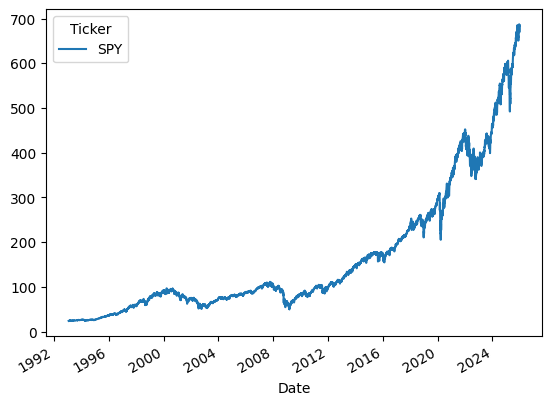

In [52]:
df.plot(y='Close')

## Return Analysis

In [53]:
df['Returns'] = df['Open'].shift(-1)/df['Open']

# Mean and Std Dev of Returns
meanReturn = df['Returns'].mean()
stdReturn = df['Returns'].std()

print(f"Mean return of SPY is : {meanReturn}")
print(f"Std Dev of return of SPY is : {stdReturn}")

Mean return of SPY is : 1.000471699286449
Std Dev of return of SPY is : 0.011681771831934896


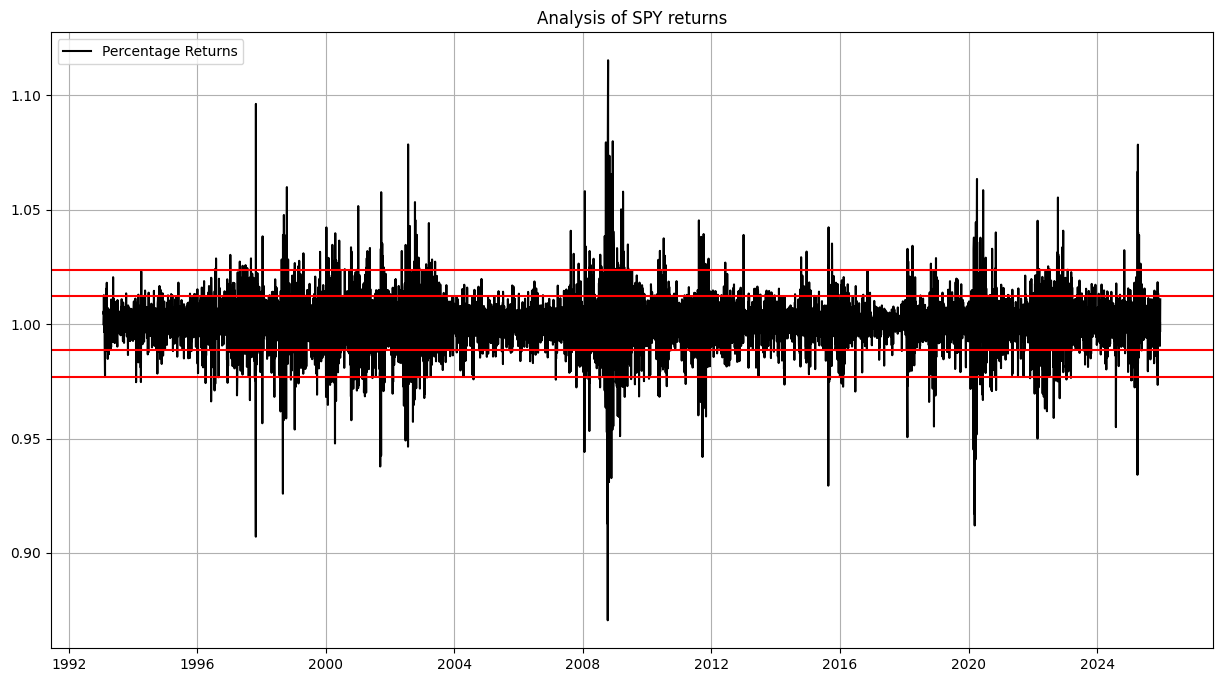

In [54]:
# Plot
plt.figure(figsize =(15, 8))
plt.title("Analysis of SPY returns")
plt.plot(df['Returns'], color='black',label='Percentage Returns')
plt.axhline(y=meanReturn+(stdReturn*2), color='red', linestyle='-')
plt.axhline(y=meanReturn+(stdReturn*1), color='red', linestyle='-')
plt.axhline(y=meanReturn-(stdReturn*2), color='red', linestyle='-')
plt.axhline(y=meanReturn-(stdReturn*1), color='red', linestyle='-')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Returns Distribution

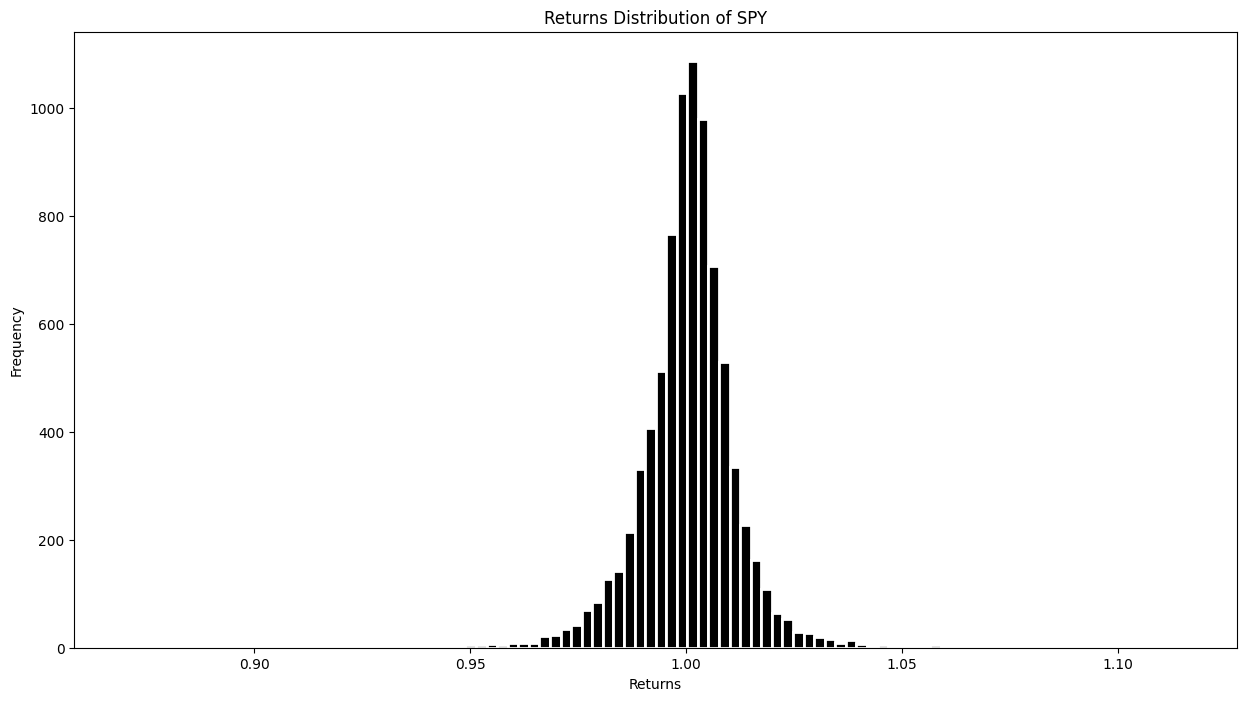

In [55]:
plt.figure(figsize=(15, 8))
plt.hist(df['Returns'], color='black', edgecolor='white', linewidth=2, bins=100)
plt.title("Returns Distribution of SPY")
plt.xlabel('Returns', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

## Volatilty Analysis

In [56]:
df['Volatility']=df['High']/df['Low']
highVolatility = np.where(df['Volatility'].shift(1).ge(df['Volatility'].mean()), df['Close']/df['Open'], 0)
highVolatility = highVolatility[highVolatility!=0]

print(f"Average next return on High Volality Scenarios is: {np.mean(highVolatility)}")

lowVolatility = np.where(df['Volatility'].shift(1).lt(df['Volatility'].mean()), df['Close']/df['Open'], 0)
lowVolatility = lowVolatility[lowVolatility!=0]

print(f"Average next return on Low Volality Scenarios is: {np.mean(lowVolatility)}")

Average next return on High Volality Scenarios is: 1.0000706745048233
Average next return on Low Volality Scenarios is: 1.0000706745048278


## Techincal Analysis Indicators

In [57]:
price_cols = ['Open', 'High', 'Low', 'Close']
df[price_cols] = df[price_cols].apply(pd.to_numeric, errors='coerce')

<Axes: xlabel='Date'>

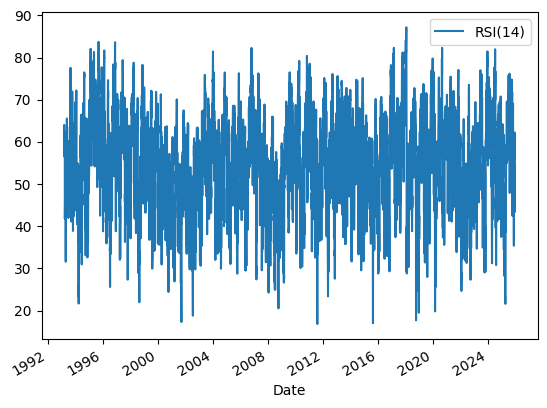

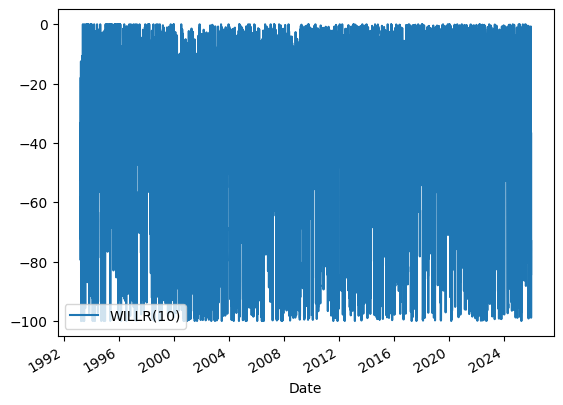

In [60]:
try:
  import pandas_ta as ta
except:
  !pip install -q pandas_ta
  import pandas_ta as ta

df['RSI(2)'] = ta.rsi(close=df[('Close', 'SPY')], length=2)
df['RSI(14)'] = ta.rsi(close=df[('Close', 'SPY')], length=14)
df["Close/movingAverage(14)"] = df[('Close', 'SPY')]/ta.sma(close=df[('Close', 'SPY')], length=14)
df["Close/movingAverage(30)"] = df[('Close', 'SPY')]/ta.sma(close=df[('Close', 'SPY')], length=30)
df["WILLR(10)"] = ta.willr(high=df[('High', 'SPY')], low=df[('Low', 'SPY')], close=df[('Close', 'SPY')], length=10)

df = df.dropna()

# Plots of indicator
df.plot(y='RSI(14)')
df.plot(y='WILLR(10)')

## Simple Backtest

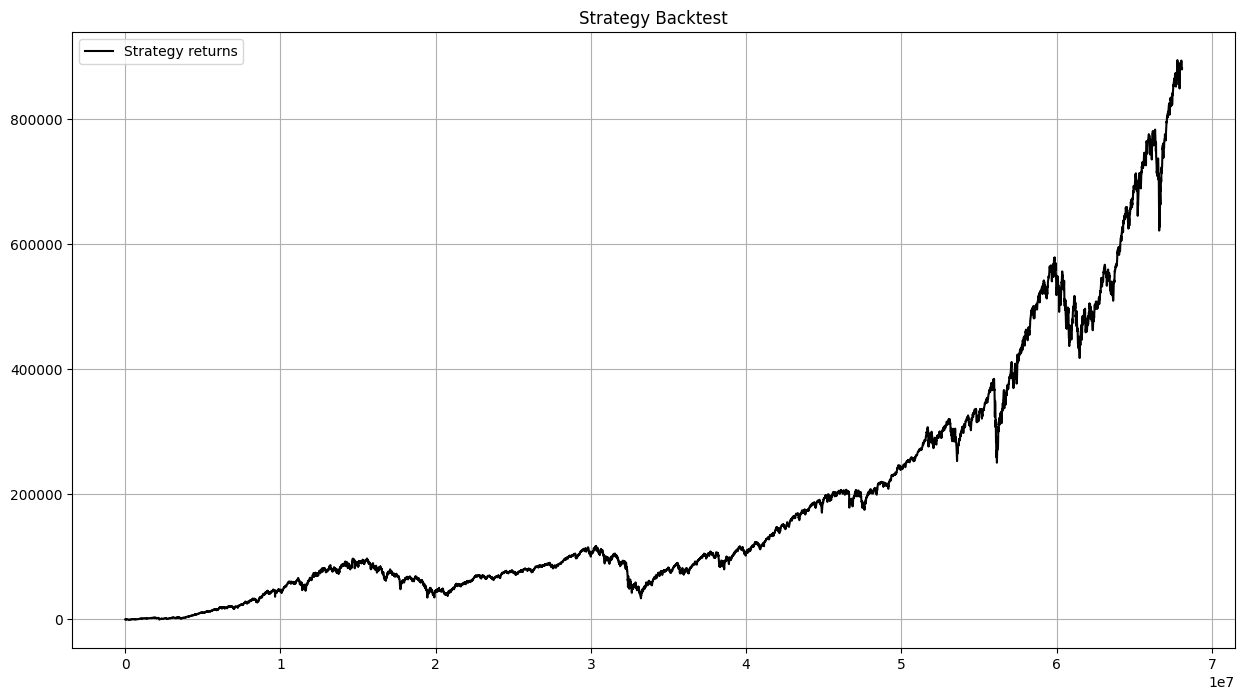

In [61]:
strategy = np.where((df['RSI(2)'].lt(50)) & (df['Close/movingAverage(30)'].lt(0.99)),
                    df['Open'].shift(-2)-df['Open'].shift(-1),
                    0
                    )

plt.figure(figsize=(15, 8))
plt.title("Strategy Backtest")
plt.plot(np.cumsum(strategy), color='black', label='Strategy returns')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Correlation Analysis

Correlation between SPY and TLT  0.606838241563054


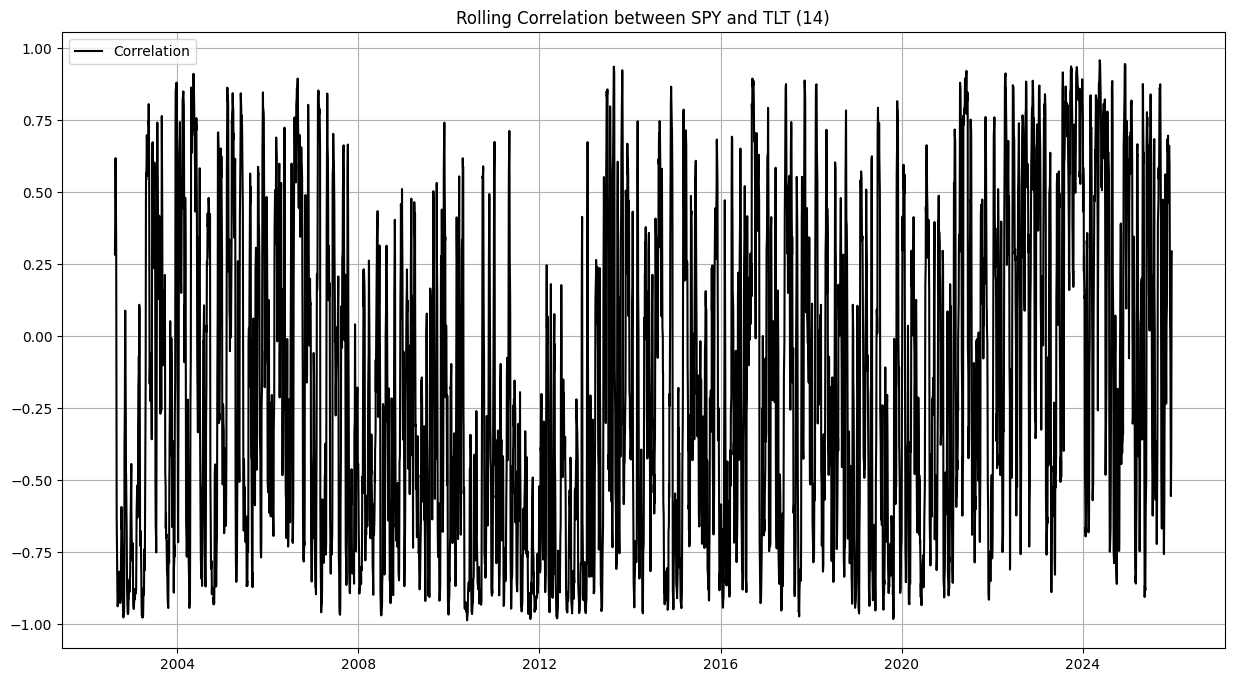

In [73]:
# SPT TLT

df2= yf.download(["SPY", "TLT"],
                 start=date.today()-timedelta(days=365*50),
                 end=date.today(),
                 progress=False,)

print("Correlation between SPY and TLT ", df["Close", "SPY"].corr(df2["Close","TLT"]))

df['rollingCorr14'] = df['Close', 'SPY'].rolling(14).corr(df2['Close', 'TLT'])
df=df.dropna()

plt.figure(figsize=(15, 8))
plt.title("Rolling Correlation between SPY and TLT (14)")
plt.plot(df['rollingCorr14'], color='black', label='Correlation')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Intermarket Strategy

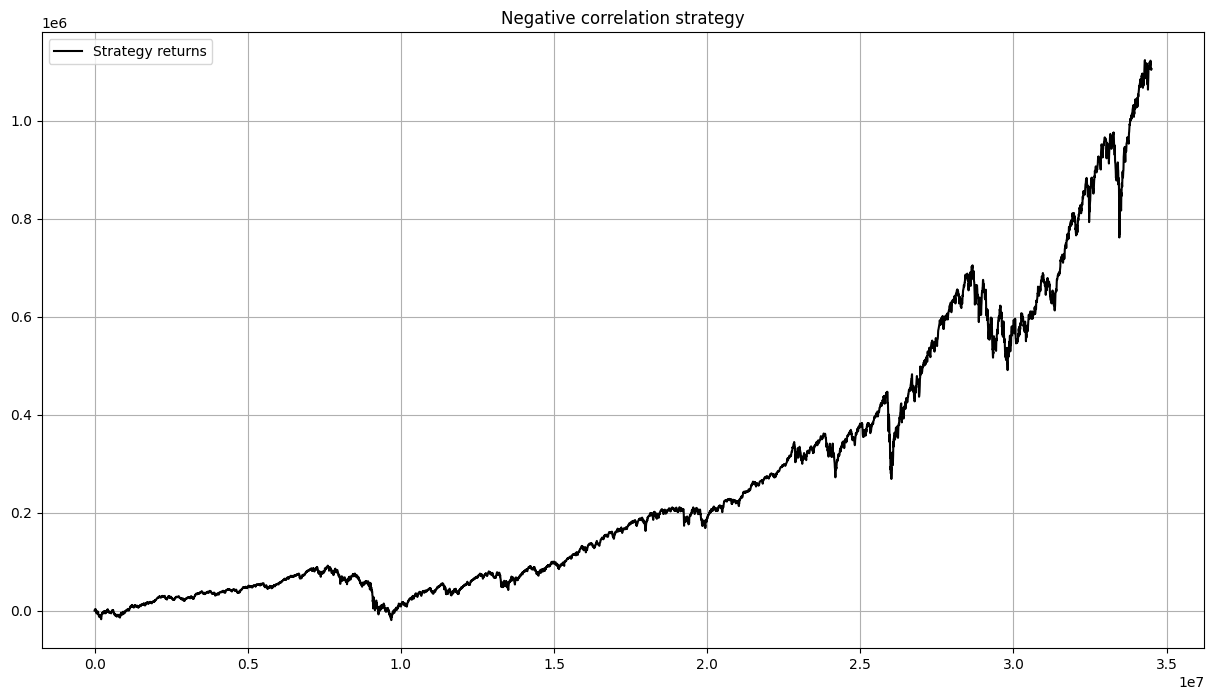

In [74]:
strategy = np.where(df['rollingCorr14'].lt(-0.6),
                    df['Open'].shift(-2) - df['Open'].shift(-1),
                    0)
plt.figure(figsize=(15, 8))
plt.title("Negative correlation strategy")
plt.plot(np.cumsum(strategy), color='black', label='Strategy returns')
plt.legend(loc='upper left')
plt.grid()
plt.show()